https://www.youtube.com/watch?v=_eSGWNqKeeY

# 간단한 EDA

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import re
import torch

In [2]:
path = "./data"
train_df = pd.read_csv(path + "/train.csv")
test_df = pd.read_csv(path + "/test.csv")
print(' Done.')

 Done.


In [3]:
# Display the first five rows of the table.
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 불용어 제거하여 corpus만들기

In [4]:
# 불용어 제거: @를 포함한 태그 문구 삭제, 링크 주소 삭제
docs = [[word for word in sent if not any('http')] for sent in train_df.text]

In [5]:
#부호를 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

In [6]:
# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower()[:4] not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = ['http']

In [7]:
#전처리 적용(부호 제거해 주고 소문자로 바꿔주고 불용어(홈페이지 주소)도 제거)
train_df['text'] = train_df['text'].apply(alpha_num)
train_df['text'] = train_df['text'].str.lower()
train_df['text'] = train_df['text'].apply(remove_stopwords)

In [8]:
[i for i in train_df.tail(1).text]

['the latest more homes razed by northern california wildfire abc news']

### 누락값 처리

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [10]:
# 누락값의 개수
np.count_nonzero(train_df.keyword.isnull())

61

In [11]:
# 누락값이 아닌 자료 개수
train_df.keyword.count()

7552

In [12]:
# keyword 없는 행이 전체 자료들에서 차지하는 비중이 작으므로 삭제
train_df = train_df[train_df['keyword'].notna()]
train_df.shape

(7552, 5)

단어별 재난 연관률

In [13]:
keywords_targets = train_df.groupby('keyword')['target'].mean()

In [14]:
keywords_targets

keyword
ablaze                 0.361111
accident               0.685714
aftershock             0.000000
airplane%20accident    0.857143
ambulance              0.526316
                         ...   
wounded                0.702703
wounds                 0.303030
wreck                  0.189189
wreckage               1.000000
wrecked                0.076923
Name: target, Length: 221, dtype: float64

In [15]:
k_t_corelation = pd.DataFrame(keywords_targets)

In [16]:
k_t_corelation = k_t_corelation.sort_values(by='target', ascending=False)
k_t_corelation.head()

,target
keyword,
debris,1.000000
wreckage,1.000000
derailment,1.000000
outbreak,0.975000
oil%20spill,0.973684


In [18]:
keywords_targets.shape

(221,)

해당 단어 등장 대비 실제 재해 트윗인 비율을 기준으로 221개의 keyword 중, 상위 5개 단어를 뽑아봄: 특히 debris, wreckage, derailment 이 3개 단어는 등장했을 경우 모두 재난 상황을 지칭한 경우였음

#### 재난 상황 트윗 임의로 10개 뽑아 관찰

In [19]:
import textwrap
import random

# Wrap text to 80 characters
wrapper = textwrap.TextWrapper(width = 80)

# filter to just the 'Disaster' comments
disaster_examples = train_df.query('target == 1')['text']

# Randomly choose some examples
for i in range(10):
    j = random.choice(disaster_examples.index)
    print('')
    print(wrapper.fill(disaster_examples[j]))
    print('')


national briefing west california spring oil spill estimate grows documents
released on wednesday disclos


durbanknight rescuers are searching for hundreds of migrants in the
mediterranean after a boat carr nosybe


israel wrecked my home now it wants my land


etribune us drone attack kills 4suspected militants in north waziristan
acebreakingnews


severe tstorm warning for union county 345pm top threats include heavy rain
lightning amp damaging winds


photo lavenderpoetrycafe the forgotten history of sexual trauma hysteria was an
affliction seen primarily


incredulous at continued outcry of welfare being a waste of taxpayers money but
never similar objection to 100bn on nuclear weapons


csaresu american tragedy


we want to see no more hiroshima and nagasaki nuclear bomb disaster in this
beautiful worldlets be peaceful amp save this human civilization


travelelixir any idea whats going on i hear no sirens but this damn helo is
flying so low my apt is shaking



In [20]:
# What percentage of the comments are disaster tweets?
total_tweets = len(train_df)
num_disasters = len(train_df.query('target == 1'))

print('{:,}개의 트윗 중 {:,}개는 재난 관련 트윗임({:.2%}).'.format(total_tweets, num_disasters, num_disasters/total_tweets))

7,552개의 트윗 중 3,229개는 재난 관련 트윗임(42.76%).


keyword == NaN인 행들을 날린 train_df는 재난 트윗과 재난이 아닌 트윗이 꽤 균형 있게 존재한다.

다양한 python format 형식들: https://www.w3schools.com/python/ref_string_format.asp

In [21]:
# 전처리된 train_df의 text들 중 가장 긴 tweet의 단어 개수와 가장 짧은 단어 개수 출력
total_mx = max([len(length) for length in train_df.text])
total_mn = min([len(length) for length in train_df.text])
disaster_mx = max([len(length) for length in train_df.query('target == 1')])
disaster_mn = min([len(length) for length in train_df.query('target == 1')])

print('전체 tweets 중 최대 길이: {:>,}, 최소 길이 {:>,} \n재해 tweets 중 최대 길이: {}, 최소 길이 {}'.format(total_mx, total_mn, disaster_mx, disaster_mn))

전체 tweets 중 최대 길이: 143, 최소 길이 5 
재해 tweets 중 최대 길이: 8, 최소 길이 2


# BERT Input Length Limitation

In [22]:
from transformers import BertTokenizer

print("Load Bert_Tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Load Bert_Tokenizer...


BertTokenizer이 어떻게 작동되는지 살펴보기

In [23]:
# 첫 번째 텍스트 꺼내오기
sample_text = train_df.iloc[0].text

# Run the tokenizer to count up the number of tokens. The tokenizer will split the text into words, punctuations and subwords as needed
tokens = tokenizer.tokenize(sample_text)

print('train_df의 첫 번째 text에는 {:,}개의 WordPiece Tokens를 가지고 있다'.format(len(tokens)))
print('\nOriginal Text:\n')
print(wrapper.fill(sample_text))

train_df의 첫 번째 text에는 7개의 WordPiece Tokens를 가지고 있다

Original Text:

bbcmtd wholesale markets ablaze


In [24]:
# 토큰 리스트 출력
print('==== Tokens ====\n')
print(wrapper.fill(str(' '.join(tokens))))
print('')

==== Tokens ====

bbc ##mt ##d wholesale markets ab ##laze



##으로 끊긴 부분은 subword로 끊어 학습한 것

### 모든 트윗들 Bert 이용하여 Tokenize

In [25]:
import numpy as np

# 모든 문장 토크나이징 하고 kewwords에 따라 분류하기
input_ids  = []

# 각 트윗의 토큰 개수 기록
token_len = []

print('Tokenizing Tweets...')

# 각 트윗 마다...
for tweet in train_df.text:
    # 진행 상황
    if ((len(input_ids) % 200) == 0):
        print(' Read {:,} tweets.'.format(len(input_ids)))
    
    # encode will
    # 1)트윗을 토크나이징하고, 
    # 2)[CLS]토큰을 시작 부분에, [SEP]토큰을 마지막 부분에 추가하고, 
    # 3)토큰을 해당 id에 매칭
    encoded_sent = tokenizer.encode(
        tweet, # Tweet to encode
        add_special_tokens = True,  # add_special_tokens: [CLS]와 [SEP]추가'
        # max_length = 512,  # Truncate all tweets
        # return_tensors = 'pt'  # Return pytorch tensors.
    ) 
    
    # encoded된 트윗을 리스트에 넣기
    input_ids.append(encoded_sent)
    
    # 각 트윗의 토큰 개수 기록
    token_len.append(len(encoded_sent))

print('DONE.')
print('{:>10} tweets'.format(len(input_ids)))



Tokenizing Tweets...
 Read 0 tweets.
 Read 200 tweets.
 Read 400 tweets.
 Read 600 tweets.
 Read 800 tweets.
 Read 1,000 tweets.
 Read 1,200 tweets.
 Read 1,400 tweets.
 Read 1,600 tweets.
 Read 1,800 tweets.
 Read 2,000 tweets.
 Read 2,200 tweets.
 Read 2,400 tweets.
 Read 2,600 tweets.
 Read 2,800 tweets.
 Read 3,000 tweets.
 Read 3,200 tweets.
 Read 3,400 tweets.
 Read 3,600 tweets.
 Read 3,800 tweets.
 Read 4,000 tweets.
 Read 4,200 tweets.
 Read 4,400 tweets.
 Read 4,600 tweets.
 Read 4,800 tweets.
 Read 5,000 tweets.
 Read 5,200 tweets.
 Read 5,400 tweets.
 Read 5,600 tweets.
 Read 5,800 tweets.
 Read 6,000 tweets.
 Read 6,200 tweets.
 Read 6,400 tweets.
 Read 6,600 tweets.
 Read 6,800 tweets.
 Read 7,000 tweets.
 Read 7,200 tweets.
 Read 7,400 tweets.
DONE.
      7552 tweets


train_df에서 labels 추출한 뒤, 재난 관련 트윗과 재난 관련되지 않은 트윗의 분포 보기

In [26]:
labels = train_df.target.to_numpy().astype(int)

print('{:>7,} positive (is disaster tweet)'.format(np.sum(labels)))
print('{:>7,} negative (not disaster tweet)'.format(len(labels) - np.sum(labels)))

  3,229 positive (is disaster tweet)
  4,323 negative (not disaster tweet)


In [27]:
# 토큰나이징 된 train_df의 tweet들 중 가장 긴 tweet의 단어 개수와 가장 짧은 단어 개수 출력

print('전체 tweets 중 토큰 최대 개수: {:>,}, 최소 개수: {:>,}, 중간값: {:.0f}'.format(max(token_len), min(token_len), np.median(token_len)))

전체 tweets 중 토큰 최대 개수: 55, 최소 개수: 3, 중간값: 20


### 토큰 길이 분포에 따른 시각화

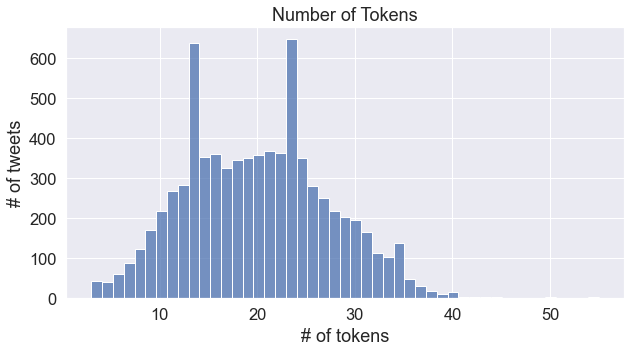

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px


sns.set(style = 'darkgrid')

# 플롯 크기랑 폰트 사이즈 키우기
sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (10, 5)

# 트윗 토큰 개수에 따른 시각화
sns.histplot(token_len, kde = False)
plt.title("Number of Tokens")
plt.xlabel('# of tokens')
plt.ylabel('# of tweets')
plt.show()

트윗의 길이와 재난 관련 트윗일 확률 간에 상관 관계 확인

In [29]:
num_pos = 0
num_neg = 0
num_pos_residual = 0

for i, l in enumerate(token_len):
    # 트윗의 개수가 30이상이라면(그래프 보고 대충 30~정도 토큰이면 긴 트윗에 속한다고 판단)
    if l >= 30:
        # 해당 긴 트윗이 재난 관련 트윗인지 아닌지 판단하여 개수 세기
        if labels[l] == 1:
            num_pos += 1
        else:
            num_neg += 1
    else:
        if labels[l] == 1:
            num_pos_residual += 1
            
            
# 결과 보고
print("Among tweets that have over 30 tokens, {:,}({:.1%}) are disaster tweets.".format(num_pos, num_pos/(num_pos+num_neg)))
print("Among overall tweets, {:,}({:.1%}) are 'Disaster Tweets'.".format(num_pos+num_pos_residual, (num_pos+num_pos_residual)/len(token_len)))

Among tweets that have over 30 tokens, 256(29.9%) are disaster tweets.
Among overall tweets, 2,701(35.8%) are 'Disaster Tweets'.


트윗의 길이와 재난 관련 트윗일 가능성 간의 상관관계가 크지 않다.

### 트윗들 padding하기

In [30]:
### 트윗들 padding하기


from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 55 #트윗당 최대 토큰 개수로 맞춰서 누락되는 토큰 아예 없애기

print('\nPadding all tweets to %d values...' % MAX_LEN)
print('\nPadding Token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# input_ids에 담긴 트윗당 토큰들을 0으로 채워넣어 Max_len 크기로 패딩하기
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype = 'long', value = 0, truncating = 'post', padding = 'post')
print('\nDONE.')


Padding all tweets to 55 values...

Padding Token: "[PAD]", ID: 0

DONE.


## Attention_Masks 만들기
Attention_mast의 역할: 실제 의미가 있는 토큰들만 따로 저장

In [31]:
attention_masks = []

# 각 트윗마다...
for sent in input_ids:
    # Attention Mask 만들기
    #  - token_id가 0이라면, 패딩이다. 마스크값에 0을 주고,
    #  - token_id가 >0이라면, 의미 있는 토큰이므로 마스크값에 1 주기!
    att_mask = [int(token_id>0) for token_id in sent]

    attention_masks.append(att_mask)

---

학습용 데이터 90%와 검증용 데이터 10%로 나누기

In [32]:
from sklearn.model_selection import train_test_split

# 훈련 90% 검증 10%로 나누기
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state = 2018, test_size = 0.1)

# 마스크도 나누어 주기
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state = 2018, test_size = 0.1)

BERT 모델은 넘파이보다 파이토치 텐서를 입력값으로 받으므로 파이토치로 변환

In [33]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

DataLoader class로 iterator만들다. For loop으로 iterate할 때와는 달리, 전체 데이터셋이 메모리에 로드될 필요가 없기에 이렇게 입력값을 먹이는게 메모리 절약에 효과적

In [34]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# DataLoader는 훈련을 위해 배치 사이즈를 알아야 한다.
# 특정 과제를 위해 BERT를 fine-tuning할 때 배치 사이즈 16 혹은 32가 권장된다. 
batch_size = 32

# training_set을 위한 Data_loader 만들기
train_data= TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

# validation_set을 위한 Data_Loader 만들기
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

# Bert Fine-Tuning
: 사전 훈련된 BERT모델이 현재의 분류 과제를 잘 수행할 수 있도록 현재 input_data로 훈련시키는 것

### 분류 모델 학습시키기

이제 우리의 input_data들이 알맞은 형태로 정리되었으니 BERT모델을 Fine-Tuning할 차례이다.

#### BertForSequenceClassification

pretrained 된 BERT 모델을 우리가 원하는 분류 결과를 내놓도록 하기 위해 수정한다. 그런 다음 BERT 모델을 기존에 준비한 Input_Data로 훈련시켜 모델 전체가 우리의 과제에 맞도록 조정한다.

#### BERT모델 로드

In [35]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# BertForSequenceClassification(pretrained BERT model with a single linear classificationmodel on top) 로드
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # lowercase letters만 있는 12 layers BERT 모델 버전
    num_labels = 2, #이진 분류이므로 2. 다중 분류에서는 숫자 늘리면 됨.
    output_attentions = False, # 모델이 attentions weights를 반환하는지 여부
    output_hidden_states = False # 모델이 모든 hidden states를 반환하는지 여부
)

# model.cuda()  #GPU로 모델 돌릴거라고 말해줌

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### Optimizer & Learning Rate Scheduler

모델이 로드되었으니 하이퍼파라미터를 설정.\
Fine-Tuning에는 다음 하이퍼 파라미터 값들이 권장됨
* Batch_size: 16, 32
* Learning_rate(Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2,3,4

epsilon parameter는 모델 훈련 중 zero-division error를 막기 위한 수.\
eps = 1e-8로 아주 작은 값이다.

In [36]:
# AdamW는 huggingface library(<->pytorch)의 클래스다. W는 'Weight Decay Fix'의미하는 듯?
optimizer = AdamW(model.parameters(), 
                  lr = 2e-5, 
                  eps = 1e-8
                 )

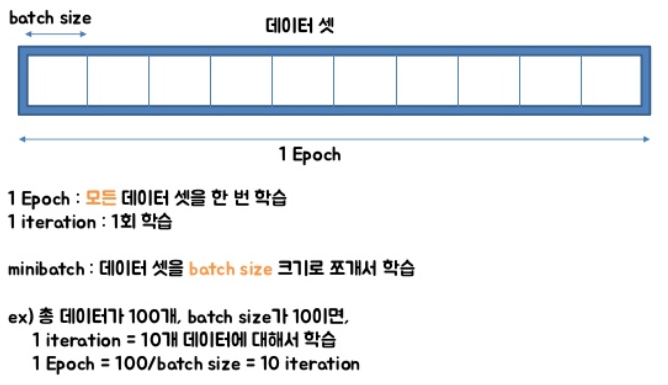

In [37]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

# Total number of training steps = # of batchs(전체 데이터셋이 몇개의 batch로 구성되는지) * # of epochs
total_steps = len(train_dataloader)* epochs

# learning rate scheduler 만들기
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # run_glue.py의 기본값
                                            num_training_steps = total_steps)

#### 훈련 루프

루프가 한 번씩 돌때마다, 모델이 전체 훈련 데이터를 가지고 학습하고 남겨놓은 검증 데이터를 통해 정확도 계산

정확도 측정 위한 helper 함수 정의

In [38]:
import numpy as np

# labels와 예측치 비교로 정확도를 계산하는 함수 
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(lebels_flat)

경과한 시간을 측정하기 위한 helper function

In [39]:
import time
import datetime

def format_time(elapsed):
    # 근접한 초로 반올림하기
    elapsed_rounded = int(round(elapsed))
    # hh:mm:ss 형태로 반환
    return str(datetime.timedelta(seconds = elapsed_rounded))

#### Training 시작!!!!!

In [40]:
device = torch.device('cpu')

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

# 매 에폭마다 평균 loss 저장(나중에 plot으로 시각화 할거임)
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #                 Training
    # ========================================
    # Training set 전체 한 번 쭈욱 학습
    print("")
    print('=== Epochs {:} / {:} ==='.format(epoch_i+i, epochs))
    print("Training...")
    
    # 에폭당 훈련 시간이 얼마나 걸리는지 측정하기 위해 훈련 시작 전 시간 측정
    t0 = time.time()
    
    # 에폭당 훈련 들어가기 전 loss값 초기화
    total_loss = 0
    
    # 모델을 training 모드로 설정(아직 훈련 시작한 것은 아님)
    model.train()
    
    for step, batch in enumerate(train_dataloader):  # 훈련 데이터의 각 배치당
        
        # 배치 100개가 학습될 때마다 진행 상황 표시
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            # 진행 상황 보고(전체 배치 중 몇 개 배치까지 학습했는지)
            print(' Batch  {:>} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        # DataLoader에서 training set unpack: unpack하며 to()매서드 통해 tensor들 cpu에 복사
        # bathc는 3개의 pytorch tensors를 포함하고 있다:
        # [0]: input_ids
        # [1]: attention_masks
        # [2]: labels
        b_input_ids = batch[0].to(device).long()
        b_input_mask = batch[1].to(device).long()
        b_labels = batch[2].to(device).long()
        
        # 역전파하기 전 이전에 계산된 gradients들 없애주기(단, RNN할 때는 이전 기울기 남겨두어야)
        model.zero_grad()
        
        # 순전파 실행: 해당 훈련 배치에 대한 모델의 훈련 평가
        # labels(train_df의 target값)를 제공해 주었기 때문에 모델 실행으로 오류값이 반환됨
        outputs = model(b_input_ids,
                        token_type_ids = None, 
                        attention_mask = b_input_mask,
                        labels = b_labels
                       )
        # model의 호출 결과 반환값은 튜플의 형태를 띠므로 loss값을 ouputs에서 끌어내 주어야 한다.
        loss = outputs[0]
        
        # 모든 batch들의 training loss 누적 합산하여 마지막에 average loss구할 수 있도록 하기
        # loss는 한 개의 값을 가지고 있는 tensor이다. .item()매서드 통해서 tensor에서 python value 꺼내와주기
        total_loss += loss.item()
        
        # gradient계산 위해 역전파 수행
        loss.backward()
        
        # gradients의 표준을 1로 고정(clip)시켜 'Exploding gradients'문제 예방
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # parameters update하고 계산된 기울기를 이용해 다음 스텝으로 나아감
        # 여기서 optimizer는 업데이트 규칙(파라미터가 그들의 기울기, 학습률 등을 근거로 어떻게 수정될 것인가)을 정해줌.
        optimizer.step()
        
        # 학슬률 업데이트
        scheduler.step()
    
    # training data 전체에 걸친 평균 loss 계산
    avg_train_loss = total_loss/ len(train_dataloader)
    
    # 학습 곡선 그리기 위해 loss값 저장
    loss_values.append(avg_train_loss)

    print("")
    print(" Average training loss: {:.2f}".format(avg_train_loss))
    # 한 에폭 학습당 걸린 시간 출력
    print(" Training Epoch took: {:}".format(format_time(time.time() - t0)))


=== Epochs 7551 / 4 ===
Training...


C:\Users\SGI\anaconda3\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
